# De Maxwell-Boltzmann snelheidsverdeling

## Doelen
We hebben al gezien in het vorige werkblad dat de snelheid van de deeltjes en de temperatuur aan elkaar gerelateerd zijn. In dit werkblad gaan we dat verder bekijken.

Eerst nemen we alle delen over van de code die we opnieuw moeten gebruiken:
- class voor particles
- functies voor een lijst aan deeltjes

Daarna voegen we de code toe voor het bekijken van de dynamiek van de deeltjes:
- We kijken naar de verschillende richtingen
- We bepalen de kansverdeling van de snelheden van de deeltjes

Zie voor de verdere inhoudelijke achtergrond de [Feynman lectures on Physics](https://www.feynmanlectures.caltech.edu/I_40.html).

## Laden van eerdere code

Eerst nemen we de pakketten van Python en de constanten voor de simulatie over. Voer je eigen getallen in, die je ook in de vorige werkbladen hebt gebruikt.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.optimize import curve_fit

BOX_SIZE_0 = 10.0        # [nm] hoogte en breedte startvolume
N = 40                   # [-] aantal deeltjes
V_0 = 420                # [m/s] startsnelheid
RADIUS = 0.3             # [nm] straal van moleculen
DT = 1.0e-6              # [s] tijdstap (v*DT << 2*R)
#your code/answer


Dan maken we weer gebruik van de klasse voor het deeltje:

In [13]:
class ParticleClass:
    def __init__(self, m, v, r, R):
        """ maakt een deeltje (constructor) """
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)  
        self.R = R

    def update_position(self):
        """ verandert positie voor één tijdstap """
        self.r += self.v * DT 
            
    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)
    
def collide_detection(p1: ParticleClass, p2: ParticleClass) -> bool:
    """ Geeft TRUE als de deeltjes overlappen """
    return np.linalg.norm(p1.r - p2.r) < (p1.R + p2.R)


def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """ past snelheden aan uitgaande van overlap """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)
    # Als deeltjes van elkaar weg bewegen dan geen botsing
    if dot_product >= 0: # '='-teken voorkomt ook problemen als delta_r == \vec{0}
        return
    distance_squared = np.dot(delta_r, delta_r) 
    # Botsing oplossen volgens elastische botsing in 2D
    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r

En we laten de deeltjes met de wanden botsen, zodat er sprake is van een druk en een temperatuur in een gesloten volume.

In [14]:
def box_collision(particle: ParticleClass):
    ''' botsing met harde wanden '''
    if abs(particle.r[0]) + particle.R > BOX_SIZE_0/2: 
        particle.v[0] = -particle.v[0]                                        # Omdraaien van de snelheid
        particle.r[0] = np.sign(particle.r[0]) * (BOX_SIZE_0/2 - particle.R)  # Zet terug net binnen box                 
    if abs(particle.r[1]) + particle.R > BOX_SIZE_0/2: 
        particle.v[1] = -particle.v[1]     
        particle.r[1] = np.sign(particle.r[1]) * (BOX_SIZE_0/2 - particle.R) 

## Functies aan een lijst van deeltjes

Waarbij we al deze functies uitvoeren en samennemen over een lijst met deeltjes:

In [15]:
def create_particles(particles):
    """ Leegmaken en opnieuw aanmaken van deeltjes  in lijst """
    particles.clear()
    for i in range(N):
        vx = np.random.uniform(-V_0, V_0)
        vy = np.random.choice([-1, 1]) * np.sqrt(V_0**2 - vx**2)        
        pos = np.random.uniform(-BOX_SIZE_0/2 + RADIUS, BOX_SIZE_0/2 - RADIUS, 2)
        particles.append(ParticleClass(m=1.0, v=[vx, vy], r=pos, R=RADIUS))
        
def handle_collisions(particles):
    """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles[i], particles[j]):
                particle_collision(particles[i], particles[j])

def handle_walls(particles):
    """ botsing met wanden controleren voor alle deeltjes in lijst """
    for p in particles:
        box_collision(p)

def take_time_step(particles):
    """ zet tijdstap voor een lijst deeltjes en verwerk alle botsingen onderling en met wanden """
    for p in particles:
        p.update_position()
    handle_collisions(particles)
    handle_walls(particles)  

## Eerste simulatie ter controle

Zoals we inmiddels gewend zijn draaien we eerst een korte simulatie om te verifiëren of alle code correct is overgenomen:

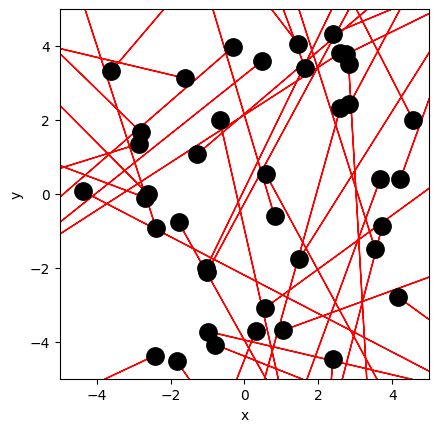

In [16]:
particles = []
create_particles(particles)
for i in range(100):
    take_time_step(particles)

plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.xlim(-BOX_SIZE_0/2, BOX_SIZE_0/2)
plt.ylim(-BOX_SIZE_0/2, BOX_SIZE_0/2)

for p in particles:
    plt.plot(p.r[0], p.r[1], 'k.', ms=25)
    plt.arrow(p.r[0], p.r[1], p.v[0], p.v[1], 
              head_width=0.05, head_length=0.1, color='red')
plt.show()

## Equipartitiebeginsel

Dit beginsel is heel belangrijk voor de thermodynamica en stelt dat de energie in thermodynamisch evenwicht gelijk wordt verdeeld over de toegankelijke vrijheidsgraden. Laten we dit eerst verifiëren in onze simulatie.

```{exercise} 
:label: ex-boltzmann-1
Maak een alternatieve vorm van de functie `create_particles` die alle deeltjes een beginsnelheid `V_0` volledig in de verticale richting geeft. Laat de regel `particles.clear()` staan. Deze zorgt ervoor dat je de lijst eerst leegmaakt als je een nieuwe beginsituatie wilt creëren en de variabele al eerder is aangemaakt. 
```

In [17]:
def create_uniform_particles(particles):
    """Leegmaken en opnieuw aanmaken van deeltjes met uniforme verticale snelheid"""
    particles.clear()
    for i in range(N):
        vx = 0.0
        vy = np.random.choice([-1, 1]) * V_0
        pos = np.random.uniform(
            -BOX_SIZE_0/2 + RADIUS,
             BOX_SIZE_0/2 - RADIUS,
             2
        )
        particles.append(
            ParticleClass(
                m=1.0,
                v=[vx, vy],
                r=pos,
                R=RADIUS
            )
        )



```{exercise}
:label: ex-boltzmann-2
Creëer `N` deeltjes met deze functie en plot hiervan de kinetische energie in de $x-$ en de $y-$richting als functie van tijd. Neem zoveel tijdstappen als dat er in principe nodig zijn om de deeltjes twee keer de lengte van het volume af te laten leggen. 
```

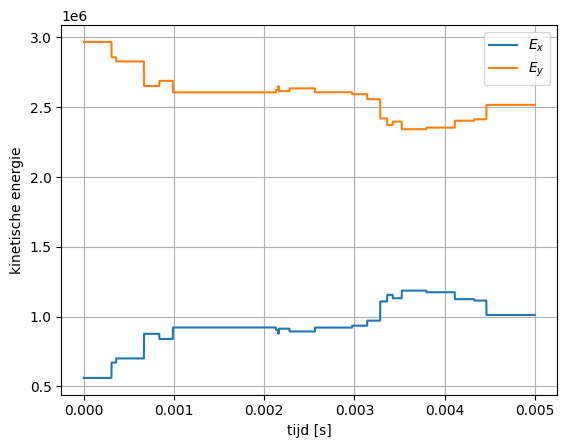

In [18]:
# kinetische energie per richting
def kinetic_energy_x(particles):
    return sum(0.5 * p.m * p.v[0]**2 for p in particles)

def kinetic_energy_y(particles):
    return sum(0.5 * p.m * p.v[1]**2 for p in particles)

# aantal tijdstappen: deeltjes leggen ~2x boxlengte af
n_steps = 5000

# initialisatie
particles = []
create_uniform_particles(particles)

# opslag
times = []
E_x_list = []
E_y_list = []

# simulatie
for step in range(n_steps):
    take_time_step(particles)
    times.append(step * DT)
    E_x_list.append(kinetic_energy_x(particles))
    E_y_list.append(kinetic_energy_y(particles))

# plot
plt.figure()
plt.plot(times, E_x_list, label=r'$E_x$')
plt.plot(times, E_y_list, label=r'$E_y$')
plt.xlabel('tijd [s]')
plt.ylabel('kinetische energie')
plt.legend()
plt.grid()
plt.show()



Aan het resultaat van je simulatie kan je zien dat de deeltjes zich inderdaad gedragen volgens equipartitiebeginsel. Afwijkingen van het gemiddelde zijn het gevolg van de statistiek en worden voor grotere aantallen deeltjes relatief kleiner. 

## De snelheidsverdeling

In het vorige werkblad hebben we al gezien dat er een relatie is tussen de snelheid van de deeltjes en de temperatuur. Je kan hierdoor al vermoeden dat de snelheid van de deeltjes wordt gegeven door een verdeling die van de temperatuur afhangt. De vraag is dus of we deze functie kunnen vinden.  

Om de snelheidsverdeling van de deeltjes te bepalen kan je gebruik maken van de functie histogram van python. Laten we daarom een simulatie draaien waarin we vanuit een willekeurige beginsituatie 100 tijdstappen zetten en daarna de snelheidsverdeling plotten:

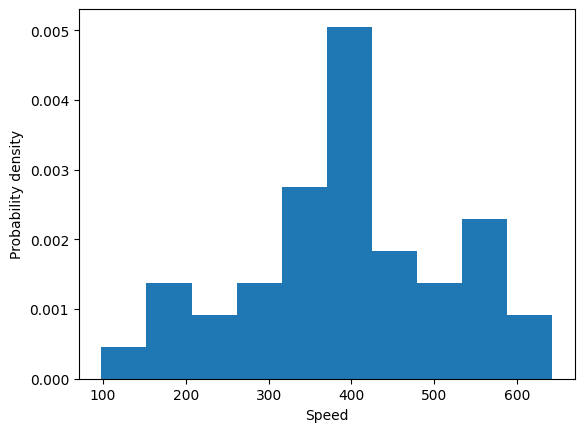

In [19]:
particles = []

create_particles(particles)

num_steps = 3000
for i in range(num_steps):
    take_time_step(particles)

speeds = [np.linalg.norm(p.v) for p in particles]
counts, bins = np.histogram(speeds, bins=10, density=True)

plt.figure()
plt.xlabel('Speed')
plt.ylabel('Probability density')
plt.stairs(counts, bins, fill=True)
plt.show()



### Voldoende statistiek

Als je de simulatie hierboven een aantal keer uitvoert, dan zal je zien dat de statistiek onvoldoende is om een reproduceerbaar antwoord te krijgen. We kunnen het aantal deeltjes toe laten nemen om meer statistiek te krijgen, maar dat kost heel veel rekenkracht. Het is een goedkopere oplossing om de statistiek te bepalen op verschillende momenten in de tijd en deze statistische resultaten te middelen. De onderstaand code laat de deeltjes 5000 tijdstappen zetten en noteert de snelheid van alle deeltjes op elke 250e tijdstap. Het histogram wordt dan bepaald door de snelheden bij elke 250e tijdstap samen te nemen. 

Door de simulatie een aantal keer te draaien zie je dat de verdeling al een stuk stabieler wordt. 

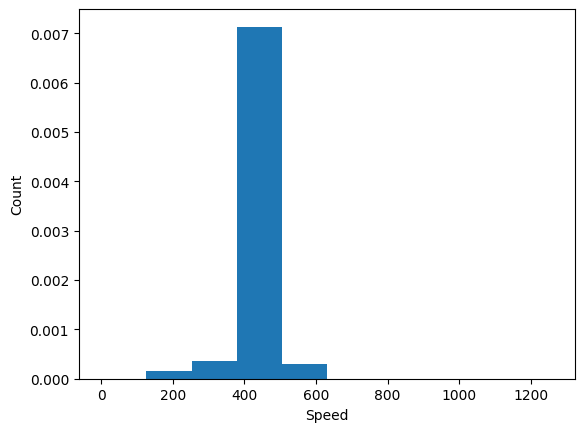

In [20]:
particles = []
num_bins = 10
tot_counts = np.zeros(num_bins, dtype=float)

plt.figure()
plt.xlabel('Speed')
plt.ylabel('Count')

create_uniform_particles(particles)

for i in range(5000):
    take_time_step(particles)
    if i % 250 == 0:
        speeds = [np.linalg.norm(p.v) for p in particles]
        partial_counts, bins = np.histogram(speeds, bins=num_bins, density='True', range=[0,3*V_0])
        tot_counts += partial_counts

norm_counts = tot_counts / 20
plt.stairs(norm_counts, bins, fill='True')
plt.show()

### De mathematische vorm van de snelheidsverdeling

De meest algemene vorm van de snelheidsverdeling heeft de vorm $f_{2D}(\vec{v})$. Dat wil zeggen dat er bij elke unieke combinatie van $x$ en $y$-component van de snelheid een specifieke kans hoort. We weten echter al dat dit niet het geval kan zijn. De natuur heeft helemaal geen voorkeur voor richting en wij kunnen zelf kiezen hoe ons assenstelsel georiënteerd is. De kans is dus alleen afhankelijk van de modulus van de snelheid en onafhankelijk van de richting. We kunnen de verdeling daarom weergeven als $f_{2D}(v)$ (zonder pijl voor de vector). 

We kunnen de verdeling nog scherper definiëren door te stellen dat de componenten van de snelheid onderling onafhankelijk zijn. De functie $f_{2D}$ is daarom te splitsen in aparte functies voor de $x$ en $y$-richting. Combineren we dit met onze conclusie van de vorige paragraaf dan moet dus gelden dat we de functie kunnen splitsen in twee functies voor $x$ en $y$ die onderling precies hetzelfde zijn en ook hetzelfde als $f(v)$:

$$
    f_{2D}(v)=f(v_x)f(v_y)
$$

Laten we nu de snelheidsverdeling beschouwen langs een willekeurige richting $r$, die een lineaire combinatie van de $x$- en $y$-richting is. Omdat dit een deelverzameling is van de twee-dimensionale snelheidsverdeling moet bovenstaande relatie hiervoor nog steeds gelden. Om de vorm van deze functie te vinden stellen we nu een differentiaalvergelijking op door te differentiëren naar $v_x$:

$$
    \frac{d}{dv_x}f(v_r)=\frac{d}{dv_x}f(v_x)f(v_y)
$$

Om de linkerkant uit te werken, passen we de kettingregel toe:

$$
    \left(\frac{\partial f(v)}{\partial v_r}\right)\left(\frac{\partial v_r}{\partial v_x}\right)=f(v_y)\frac{df(v_x)}{dv_x}
$$

Met de Stelling van Pythagoras wordt dit:

$$
    \frac{v_x}{v_r}\left(\frac{\partial f(v_r)}{\partial v_r}\right)=f(v_y) \frac{df(v_x)}{dv_x}
$$

Om deze differentiaalvergelijking op te lossen willen we een scheiding van variabelen toepassen. Daarvoor willen we eerst af van de variabele $v_y$. Dat kan door de vergelijking te delen door $f(v_r)=f(v_x)f(v_y)$ en de $v_x$ naar de andere kant te brengen:

$$
    \frac{1}{v_r f(v_r)}\left(\frac{\partial f(v_r)}{\partial v_r}\right)=\frac{1}{v_x f(v_x)} \frac{df(v_x)}{dv_x}
$$

Je kan precies dezelfde redenering ook opzetten vanuit de $y$-coördinaat in plaats van de $x$-coördinaat. De termen die je hier gevonden hebt zijn daarmee functies van verschillende en onderling onafhankelijke variabelen die toch hetzelfde antwoord geven. Ze moeten daarom constant zijn. Die constante noemen we $-2\alpha$, omdat dit de formules verderop vereenvoudigt:

$$
    \frac{1}{v_r f(v_r)}\left(\frac{\partial f(v_r)}{\partial v_r}\right)=\frac{1}{v_x f(v_x)} \frac{df(v_x)}{dv_x}=\frac{1}{v_y f(v_y)} \frac{df(v_y)}{dv_y} = -2\alpha
$$

Misschien herken je hier al de vorm die $f(v_x)$ moet hebben om hieraan te voldoen, maar om dit makkelijker te maken, kunnen we de vergelijking een beetje herschrijven:

$$
    \frac{df(v_x)}{f(v_x)}=-2\alpha v_x dv_x
$$

We kunnen beide zijden nu rustig integreren, zodat de oplossing wordt gegeven door:

$$
    f(v_x)=A \exp\left(-\alpha v_x^2\right)
$$

Bij het vak Multivariabele Analyse zal je deze integraal tegenkomen aan het einde van dit blok. Daar wordt bewezen dat de integraal onder deze functie precies "1" is als (we zeggen ook wel: de functie is _genormaliseerd_):

$$
    A = \sqrt{\frac{\alpha}{\pi}}
$$

Om ook de waarde van $\alpha$ te bepalen, kunnen we nu eisen dat deze formule de juiste waarde moet geven voor het gemiddelde van het kwadraat van de snelheid in de $x$-richting:

$$
    \left< v_x^2 \right> = \frac{kT}{m} = \sqrt{\frac{\alpha}{\pi}} \int_{-\infty}^{\infty} v_x^2 \exp\left(-\alpha v_x^2\right)dv_x
$$

Partieel integreren levert op:

$$
    \alpha = \frac{m}{2kT},
$$

zodat de snelheidsverdeling voor twee dimensies uiteindelijk de vorm heeft:

$$
    f_{2D}(v_x,v_y)=f(v_x)f(v_y)=\frac{m}{2\pi kT} \exp\left( -\frac{m(v_x^2+v_y^2)}{2kT} \right)
$$

Om hieruit de snelheidsverdeling $f_{2D}(v)$ te bepalen, moeten we nog een extra stap nemen. Het aantal combinaties van $v_x$ en $v_y$ dat overeenkomt met de snelheid $v$ is namelijk afhankelijk van $v$. Dit wordt gegeven door de cirkelomtrek met middelpunt $(v_x=0,v_y=0)$ en straal $v$. Zodoende is de snelheidsverdeling voor de modus van de snelheid gegeven door:

$$
    f_{2D}(v)=\frac{mv}{kT} \exp\left( -\frac{mv^2}{2kT} \right)
$$

```{exercise}
:label: ex-boltzmann-3
Maak een fit van het histogram dat je hierboven hebt gemaakt en haal hieruit de temperatuur. LET OP: De variabele `bins` die hierboven is gebruikt, geeft de grenzen weer van de bins. Het aantal elementen in de array `norm_counts` bevat dus een element minder dan het array `bins`. Voor het fitten moet je gebruik maken van de centrale snelheidswaardes van de bins.  
```

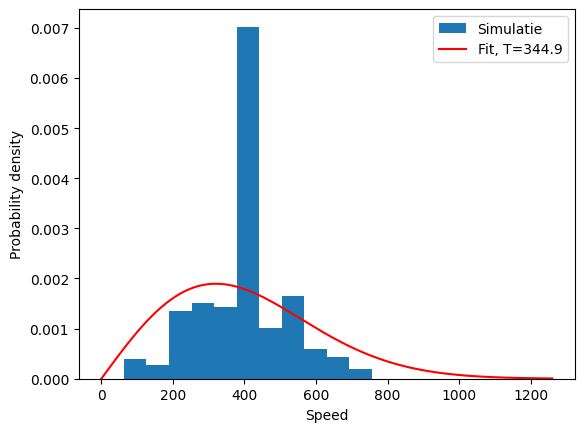

T = (344.94 ± 141.36) K


In [21]:
k_B   = 1.380649e-23   # [J/K]
M_AIR = 4.65e-26  # kg

particles = []
num_bins = 20
tot_counts = np.zeros(num_bins)

create_particles(particles)

for i in range(5000):
    take_time_step(particles)
    if i % 250 == 0:
        speeds = [np.linalg.norm(p.v) for p in particles]
        partial_counts, bins = np.histogram(
            speeds,
            bins=num_bins,
            density=True,
            range=(0, 3 * V_0)
        )
        tot_counts += partial_counts

norm_counts = tot_counts / 20

def maxwell_2D(v, T):
    return ((M_AIR*v) / (T*k_B)) * np.exp(-((v**2)*M_AIR) / (2*k_B*T))

bin_centers = 0.5 * (bins[:-1] + bins[1:])

popt, pcov = curve_fit(maxwell_2D, bin_centers, norm_counts, p0=[V_0**2 / 2])
T_fit = popt[0]
u_T = np.sqrt(pcov[0, 0])

v_fit = np.linspace(0, bins[-1], 300)

plt.figure()
plt.stairs(norm_counts, bins, fill=True, label='Simulatie')
plt.plot(v_fit, maxwell_2D(v_fit, T_fit), 'r', label=f'Fit, T={T_fit:.1f}')
plt.xlabel('Speed')
plt.ylabel('Probability density')
plt.legend()
plt.show()

print(f"T = ({T_fit:.2f} \u00b1 {u_T:.2f}) K")

```{exercise}
:label: ex-boltzmann-4
Controleer of de temperatuur van de verdeling klopt met je verwachting en overeenkomt met de constanten die je bovenaan hebt gekozen. Daarna kan je de opdracht laten afteken door de TA, of de uitgebreide opdracht maken voor een excellent.
```

### Controle van de temperatuur

In twee dimensies volgt uit het equipartitiebeginsel dat de gemiddelde kinetische energie per deeltje voldoet aan
$$
\frac{1}{2} m \langle v^2 \rangle = kT,
$$
zodat de temperatuur gegeven wordt door
$$
T = \frac{m}{2k}\langle v^2 \rangle.
$$

In de simulatie is gekozen voor $m$ = 4.65e-26 $kg$ en werken we in eenheden waarin $k$ = 1.380649e-23 $J/K$. De karakteristieke snelheid van de deeltjes is van orde $V_0$ $\approx$ 420, zodat verwacht wordt dat
$$
\langle v^2 \rangle \sim V_0^2 \quad \Rightarrow \quad T_{\text{verwacht}} \approx \frac{m}{2k}\langle V_0^2 \rangle \approx 300 K.
$$

De temperatuur die is verkregen uit het fitten van de Maxwell–Boltzmann-snelheidsverdeling ligt in dezelfde orde van grootte. Dit laat zien dat de gemeten snelheidsverdeling consistent is met de gekozen parameters en het equipartitiebeginsel.


```{exercise} 🌶 Uitbreiding
:label: ex-boltzmann-5
We kunnen deze opdracht makkelijk uitbreiden door de deeltjes van verschillende massa's in de simulatie te stoppen:

- Pas de massa van de helft van de deeltjes aan zodat hun massa 4 keer zo groot is als die van de andere helft.
- Splits het snelheidshistogram in twee kleuren: voor elke massa een aparte kleur.
- Vind de juiste grootheid, zodat de twee histogrammen voor de verschillende massa's er hetzelfde uitzien en over elkaar vallen.
- Bedenk zelf een interessante uitbreiding.